# Step 1 - Data Analysis

## Step 1.1 - Importing the Libraries

In [1]:
from pandas import read_csv
from pandas import datetime
from pandas import concat
from pandas import DataFrame
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt
from keras import regularizers
import pandas as pd
from keras.utils.vis_utils import plot_model
from pandas.tools.plotting import lag_plot
from pandas import Series
from pandas.tools.plotting import autocorrelation_plot
import numpy as np
import pydot
import graphviz

Using TensorFlow backend.


## Step 1.2 - Load the Dataset

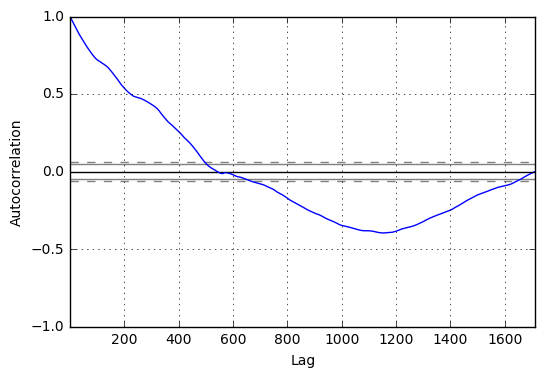

In [2]:
def parser(x):
    return datetime.strptime(x,'%m-%d-%Y')
dataset = read_csv('dataset.csv',header=0,parse_dates=[0],date_parser=parser)
series = Series.from_csv('dataset.csv',header=0)
autocorrelation_plot(series)
pyplot.show()

In [3]:
print(dataset.head())

        Date  USD/INR  BSE Sensex  Gold Price
0 2018-01-19    63.83    35511.58      1333.1
1 2018-01-18    63.87    35260.29      1327.2
2 2018-01-17    63.89    35081.82      1339.2
3 2018-01-16    64.02    34771.05      1337.1
4 2018-01-15    63.52    34843.51      1341.8


In [4]:
dataset.describe()

,USD/INR,BSE Sensex,Gold Price
count,1712.000000,1712.000000,1712.000000
mean,60.557062,23674.218954,1359.342710
std,6.052800,5131.638246,200.241992
min,44.070000,15175.080000,1050.800000
25%,55.350000,18762.852500,1222.450000
50%,62.145000,24783.465000,1287.300000
75%,65.150000,27827.757500,1563.025000
max,68.810000,35511.580000,1888.700000


In [5]:
dataset.shape

(1712, 4)

## Step 1.3 -  Plot a graph to show the trend in the exchange rates

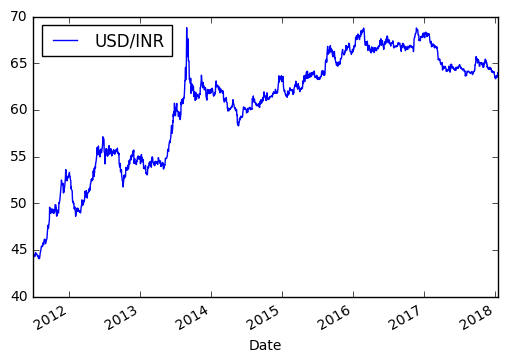

In [6]:
dataset.plot(y='USD/INR',x='Date')
pyplot.show()

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
# load dataset
dataset = read_csv('dataset.csv', header=0, index_col=0)
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5]],axis=1,inplace=True)

In [9]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.798707   1.000000   0.336914  0.800323
2   0.800323   0.987643   0.329872  0.801132
3   0.801132   0.978868   0.344194  0.806386
4   0.806386   0.963586   0.341687  0.786176
5   0.786176   0.967149   0.347297  0.789814


In [10]:
values = reframed.values
n_test = 277
train = values[n_test:,:]
test = values[:n_test,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1434, 1, 3) (1434,) (277, 1, 3) (277,)


In [11]:
model = Sequential()
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2]),kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(1))
plot_model(model, to_file='model.png',show_shapes=True)
model.compile(loss='mae', optimizer='adam',metrics=['mse'])

Train on 1434 samples, validate on 277 samples
Epoch 1/100
2s - loss: 1.8883 - mean_squared_error: 0.3939 - val_loss: 1.5826 - val_mean_squared_error: 0.3998
Epoch 2/100
0s - loss: 1.1138 - mean_squared_error: 0.2083 - val_loss: 0.8907 - val_mean_squared_error: 0.1783
Epoch 3/100
0s - loss: 0.5980 - mean_squared_error: 0.0926 - val_loss: 0.4518 - val_mean_squared_error: 0.0628
Epoch 4/100
0s - loss: 0.3658 - mean_squared_error: 0.0511 - val_loss: 0.2784 - val_mean_squared_error: 0.0213
Epoch 5/100
0s - loss: 0.2869 - mean_squared_error: 0.0399 - val_loss: 0.2248 - val_mean_squared_error: 0.0152
Epoch 6/100
0s - loss: 0.2573 - mean_squared_error: 0.0374 - val_loss: 0.2305 - val_mean_squared_error: 0.0208
Epoch 7/100
0s - loss: 0.2532 - mean_squared_error: 0.0399 - val_loss: 0.2266 - val_mean_squared_error: 0.0223
Epoch 8/100
0s - loss: 0.2498 - mean_squared_error: 0.0417 - val_loss: 0.2187 - val_mean_squared_error: 0.0213
Epoch 9/100
0s - loss: 0.2456 - mean_squared_error: 0.0423 - val_

0s - loss: 0.1031 - mean_squared_error: 9.9515e-04 - val_loss: 0.1213 - val_mean_squared_error: 0.0020
Epoch 76/100
0s - loss: 0.1017 - mean_squared_error: 9.2050e-04 - val_loss: 0.1187 - val_mean_squared_error: 0.0018
Epoch 77/100
0s - loss: 0.1004 - mean_squared_error: 8.4537e-04 - val_loss: 0.1169 - val_mean_squared_error: 0.0017
Epoch 78/100
0s - loss: 0.0991 - mean_squared_error: 7.8950e-04 - val_loss: 0.1159 - val_mean_squared_error: 0.0017
Epoch 79/100
0s - loss: 0.0980 - mean_squared_error: 7.4930e-04 - val_loss: 0.1155 - val_mean_squared_error: 0.0017
Epoch 80/100
0s - loss: 0.0970 - mean_squared_error: 7.2042e-04 - val_loss: 0.1112 - val_mean_squared_error: 0.0014
Epoch 81/100
0s - loss: 0.0955 - mean_squared_error: 6.4298e-04 - val_loss: 0.1102 - val_mean_squared_error: 0.0014
Epoch 82/100
0s - loss: 0.0945 - mean_squared_error: 6.0825e-04 - val_loss: 0.1088 - val_mean_squared_error: 0.0013
Epoch 83/100
0s - loss: 0.0934 - mean_squared_error: 5.7410e-04 - val_loss: 0.1069 - 

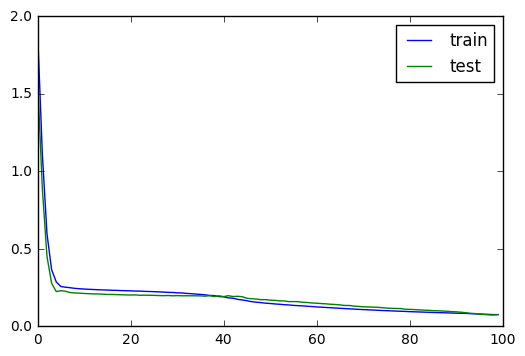

In [12]:
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
#pyplot.plot(history.history['mean_squared_error'],label='mse')
pyplot.legend()
pyplot.show()

In [13]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.300


In [14]:
inv_yhat = inv_yhat.reshape((277,1))
inv_y = inv_y.reshape((277,1))

In [15]:
inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)

In [16]:
pyplot.plot(inv_yhat,label='predicted')
pyplot.plot(inv_y,label='actual')

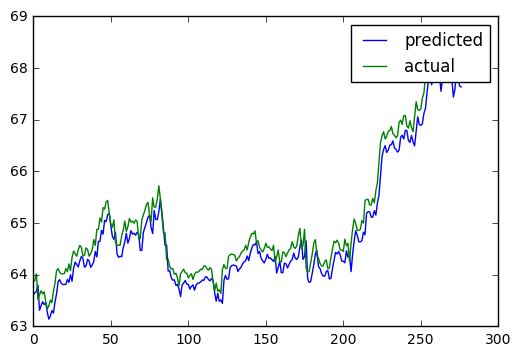

In [17]:
pyplot.legend()
pyplot.show()

In [18]:
errr = inv_y-inv_yhat

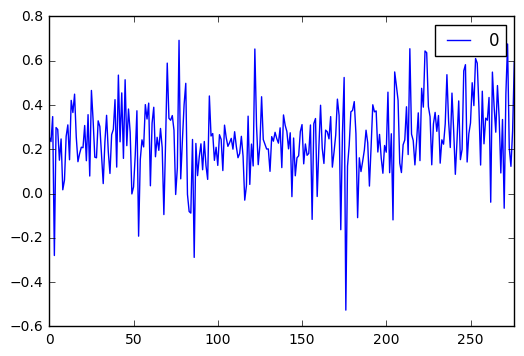

In [19]:
errr.plot()
pyplot.show()

In [20]:
errr.describe()

,0
count,277.000000
mean,0.248474
std,0.168802
min,-0.526268
25%,0.158966
50%,0.244110
75%,0.347267
max,0.692108


In [21]:
plot_model(model, to_file='model.png',show_shapes=True,show_layer_names=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 500)               1008000   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 1,008,501
Trainable params: 1,008,501
Non-trainable params: 0
_________________________________________________________________
